In [1]:
import os 
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader, ConfluenceLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain_community.embeddings import OpenAIEmbeddings
from langchain_ollama import OllamaEmbeddings

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage

from typing import TypedDict, Annotated, List
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition



from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

load_dotenv()

# os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

True

In [2]:


confluence_api_key = os.environ["CONFLUENCE_TOKEN"]
# langsmith_api_key = os.environ["LANGSMITH_API_KEY"]

# client = Client(api_key=langsmith_api_key)

# # embedding_fn = OpenAIEmbeddings()

# llm = ChatGoogleGenerativeAI(
#     model="gemini-2.0-flash",
#     temperature=0  # optional
# )

# embedding_fn = GoogleGenerativeAIEmbeddings(
#     model="models/embedding-001"  # this is the correct embedding model
# )


embedding_fn = OllamaEmbeddings(model="nomic-embed-text")

print(embedding_fn.embed_query("OAuth 2.0 is an authorization framework"))

loader1 = PyPDFLoader("InfoTech_HR_Policy_Manual.pdf")
pdf_docs = loader1.load()

loader2 = ConfluenceLoader(  
url="https://poorvashrivastav03.atlassian.net/wiki",
username="poorvashrivastav03@gmail.com",  
api_key=confluence_api_key,
space_key="TRD",      # Replace with your Confluence space key
limit=5
)
confluence_docs = loader2.load()


[0.006084328, 0.002494591, -0.15927947, -0.043639448, 0.040117614, -0.04102925, 0.0050643105, 0.01470908, 0.05307202, -0.031698048, -0.009573438, 0.01738086, 0.08602625, -0.004539801, 0.051367957, -0.024956618, -0.018199699, -0.040547904, -0.020128652, -0.09280334, 0.029042633, -0.0041551986, -0.027520707, 0.0022887045, 0.10380221, -0.0027874685, 0.02027769, 0.03687985, -0.043038364, -0.021446263, 0.02380848, -0.013956396, 0.029432617, -0.013718402, 0.02942066, -0.054840535, 0.046126906, 0.044149, -0.022711957, -0.007145242, -0.00069159217, 0.003394174, 0.05406531, 0.003485627, 0.013098579, -0.038399722, 0.023440074, 0.037694804, 0.057041995, -0.029288216, 0.0065793605, -0.03038336, -0.038474184, 0.023714822, 0.048822455, 0.02355014, 0.0022269385, 0.057828963, -0.063227266, -0.035964098, 0.04527451, 0.09091949, -0.012772981, 0.05825145, 0.041771125, -0.0043258183, -0.012139093, 0.056571614, 0.019121205, -0.013150437, 0.01752867, 0.009575644, -0.02421599, -0.016467193, -0.030467415, -0.

In [3]:

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

chunks_hr = splitter.split_documents(pdf_docs)
vector_db_hr = Chroma.from_documents(chunks_hr, embedding=embedding_fn, collection_name="internal_hr_docs")
retriever_hr = vector_db_hr.as_retriever(search_type="similarity", search_kwargs={"k": 3})


chunk_confl = splitter.split_documents(confluence_docs)
vector_db_confl = Chroma.from_documents(chunk_confl, embedding=embedding_fn, collection_name="confluence_docs")
retriever_confl = vector_db_confl.as_retriever(search_type="similarity", search_kwargs={"k": 3})



In [4]:
llm = init_chat_model("google_genai:gemini-2.0-flash")

E0000 00:00:1760511932.566604  196304 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [5]:
@tool("search_hr_docs", return_direct=False)
def search_hr_docs(query: str) -> str:
    """Returns result from the HR policy document.
    :Search HR policy documents for a given query, it might include employee policies, payroll, benefits, or leave information.
    :Do not use for technical, project, or Confluence-related queries.
    """
       
    result = retriever_hr.get_relevant_documents(query)    
    if not result:
        return "No relevant HR policy found."
    return "\n\n".join([r.page_content for r in result])

@tool("search_confluence_docs", return_direct=False)
def search_confluence_docs(query: str) -> str:    
    """Search internal Confluence pages for a given query.
    :Search Confluence for technical setup, integration, or project documentation (e.g., OAuth, Jira,APIs).
    :Do not use for HR-related queries or employee policies.
    """
    
    docs = retriever_confl.get_relevant_documents(query)     #returns a list

    if not docs:
        return "No relevant Confluence documents found."
    
    # Convert document list into plain text
    combined = "\n\n".join(
        [f"Title: {d.metadata.get('title', 'Untitled')}\n{d.page_content}" for d in docs]
    )

    print("🔍 Confluence search results:", combined[:300], "...")
    return combined



@tool("summarize_docs", return_direct=False)
def summarize_docs(text: str):
    """Summarize retrieved content for quick reference."""    
    return llm.invoke(f"Summarize briefly:\n\n{text}").content


tools = [search_hr_docs, search_confluence_docs]

llm_with_tools = llm.bind_tools(tools)
print(type(llm_with_tools))

<class 'langchain_core.runnables.base.RunnableBinding'>


In [6]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

In [11]:
def reasoning_agent(state: State):
    """LLM decides whether to answer or call a tool."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": messages + [response]}

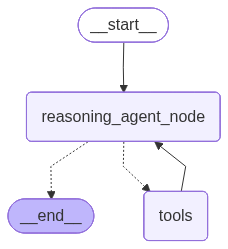

In [8]:
builder = StateGraph(State)

builder.add_node("reasoning_agent_node", reasoning_agent)
builder.add_node("tools", ToolNode(tools))

builder.set_entry_point("reasoning_agent_node")
builder.add_conditional_edges("reasoning_agent_node", tools_condition)
builder.add_edge("tools", "reasoning_agent_node")

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
response = graph.invoke({
    "messages": [HumanMessage(content="What is the leave policy?")]
})

print(response["messages"][-1].content)

response :  content='' additional_kwargs={'function_call': {'name': 'search_hr_docs', 'arguments': '{"query": "leave policy"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--e1d8b204-4d47-4e35-a402-7e1e948817d3-0' tool_calls=[{'name': 'search_hr_docs', 'args': {'query': 'leave policy'}, 'id': 'd4b741ef-54d2-44f2-a4e8-6b9e83948e04', 'type': 'tool_call'}] usage_metadata={'input_tokens': 128, 'output_tokens': 8, 'total_tokens': 136, 'input_token_details': {'cache_read': 0}}


/var/folders/mt/_ncgm8vx00b50yjykvqyd7b80000gn/T/ipykernel_7723/2037610696.py:8: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = retriever_hr.get_relevant_documents(query)


response :  content='The leave policy includes:\n- Casual Leave (CL): 10 days/year.\n- Sick Leave (SL): 12 days/year (medical certificate required for more than 2 consecutive days).\n- Privilege Leave (PL): 15 days/year (carry forward allowed up to 45 days).\n- Maternity Leave(ML): 26 weeks (as per Maternity Benefit Act).\n- Paternity Leave: 10 days.\n- Compensatory Off: For working on weekends/holidays with prior approval.\n- Public Holidays: As per State Government notifications.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--227eb94e-8678-4f63-b7aa-fff4bc34add2-0' usage_metadata={'input_tokens': 953, 'output_tokens': 125, 'total_tokens': 1078, 'input_token_details': {'cache_read': 0}}
The leave policy includes:
- Casual Leave (CL): 10 days/year.
- Sick Leave (SL): 12 days/year (medical certificate required for more than 2 consecutive days)

In [10]:
response = graph.invoke({
    "messages": [HumanMessage(content="Summarize the functional requirements of OAuth 2.0?")]
})

print(response["messages"][-1].content)

response :  content='' additional_kwargs={'function_call': {'name': 'search_confluence_docs', 'arguments': '{"query": "functional requirements of OAuth 2.0"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--0cf8136f-bf42-4672-b3a5-192e09357f8c-0' tool_calls=[{'name': 'search_confluence_docs', 'args': {'query': 'functional requirements of OAuth 2.0'}, 'id': '103b3e60-b0ce-4800-8b0b-4d2988b5d5c1', 'type': 'tool_call'}] usage_metadata={'input_tokens': 134, 'output_tokens': 15, 'total_tokens': 149, 'input_token_details': {'cache_read': 0}}
🔍 Confluence search results: Title: OAuth 2.0
#E3FCEF 1. Objective Spaces help your team structure, organize, and share work, so every team member has visibility into institutional knowledge and access to the information they need to do their best work. #E3FCEF 2. Scope In Scope Integration of Confluence with an Identity Provid ...